# Threshold optimization: offline diagnostics (0K & +/-4K Aqua) 

This script runs a number of offline diagnostics that evaluate the performance of both, SingleNNs & CausalSingleNNs (i.e., using test data), which have the architecture and hyperparameters from Rasp et al. (2018).

### Statistics

lev, averaged over lat-lon: MSE, TVAR, PVAR, $R^2$, bias

For each 3-D output variable [TPHYSTND, PHQ] the $R^2$ is computed for each level $z$ and then averaged:

$$ R^2_z = 1 - (SSE_z / TVAR_z) $$

where SSE, the sum of squared errors is computed from the predicted values $y$ and the corresponding true values $\hat{y}$:

$$ SSE_z = \frac{1}{nt \times nx \times ny}\sum_{nt}\sum_{nx}\sum_{ny} (y_{t, x, y} - \hat{y}_{t, x, y})^2$$

and the TVAR, the true variance is:

$$ TVAR_Z = \frac{1}{nt \times nx \times ny}\sum_{nt}\sum_{nx}\sum_{ny} (\hat{y}_{t, x, y} - \bar{\hat{y}})^2 $$

with $\bar{\hat{y}}$ being the true mean over $t, x, y$.

## Packages, Modules & Definitions 

In [17]:
import sys; sys.path.append("..")

import os, pickle
import numpy    as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib as mpl
from pathlib import Path

from utils.setup import SetupNeuralNetworks
from utils.setup import SetupDiagnostics
from neural_networks.cbrain.cam_constants  import *
from neural_networks.models import generate_models
from neural_networks.load_models import load_models
from neural_networks.model_diagnostics import ModelDiagnostics
from neural_networks.load_models import get_save_plot_folder


In [2]:
def get_path(setup, base_path=''):
        """ Generate a path based on this model metadata """
        path = Path(base_path)
        str_hl = str(setup.hidden_layers).replace(", ", "_")
        str_hl = str_hl.replace("[", "").replace("]", "")
        path = path / Path(
            "hl_{hidden_layers}-act_{activation}-e_{epochs}/".format(
                hidden_layers=str_hl,
                activation=setup.activation,
                epochs=setup.epochs,
            )
        )
        return path
    
    
def get_dict(pathnm, outFile):

    if os.path.isfile(str(pathnm)+'/'+outFile):
        print(f'{outFile} exists; loading...')
        infile    = open(str(pathnm)+'/'+outFile,'rb')
        eval_dict = pickle.load(infile)
        infile.close()
    else:
        print(f'{outFile} does not exists; create empty dictionary...')
        eval_dict = {}
    
    return eval_dict


def save_dict(eval_dict, pathnm, outFile, verbose=0):
    if verbose > 0:
        print(f"Save dict: {str(pathnm)}/{outFile}")
    outfile = open(str(pathnm)+'/'+outFile,'wb')
    pickle.dump(eval_dict,outfile)
    outfile.close()


# Options

In [3]:
eval_cases = ['0k', 'm4k', 'p4k']
statsnm    = 'r2' # 'r2'; 'mse'
nTime      = False # 5855 # False

## Rasp et al. profiles

In [4]:
# Rasp et al. (2018) - 2021_09_02_TEST_For_Nando.nc (nTime: 5855)
iMod = 'Rasp_etal_2018'
rasp_dict                    = {}
for i, iCase in enumerate(eval_cases):
    if iCase == '0k':
        # 0K
        phq_r2 = np.array([0., 0., 0.021066102885387128, 0.0514988411828482, -0.0025532046540444053,
         0.0005037824261638901, -0.004101913628601128, -0.0012083456230529421,
         0.016112671296461878, 0.10806858679343545, 0.335004027198747,
         0.5976419669149771, 0.7349418726449735, 0.82128715331504, 0.87480042569578,
         0.8810113213671213, 0.8581847682404499, 0.7765646142170176,
         0.6954373528333859, 0.5989878099546596, 0.4994111966358522,
         0.4348499947507394, 0.398625690784006, 0.3240667114284901,
         0.30337542894871594, 0.2833236667380076, 0.2609835973480146,
         0.23945320928486358, 0.2333829588481916, 0.24260476922337704])
        tphystnd_r2 = np.array([0.9922547699495557, 0.9849059136172208, 0.6490321732688649,
         0.6433293556591765, 0.9387710579198724, 0.9107823798258867,
         0.43556987662233315, 0.12746173753175494, 0.18006553574503814,
         0.21777084527374913, 0.304586445796036, 0.3928627442178094,
         0.5064322543677262, 0.6775126802656439, 0.8022394956438594,
         0.8588123153532324, 0.878506896512486, 0.865862758832982, 0.8463927448386868,
         0.8072296961322902, 0.74271532208224, 0.6361502766087155, 0.5110209384335604,
         0.39968810535305266, 0.3532026944004303, 0.3260791555793202,
         0.3250959325837667, 0.35142759375429844, 0.3893123499309805,
         0.38486129174806283])

    elif iCase == 'm4k':
        # -4K
        phq_r2 = np.array([0., 0., 0.004271052870761127, -0.03301561850730028, -0.028421927769762823,
         -0.1402430654519793, -0.09069849684249598, -0.08232323904204408,
         -2.244297521970445, -8.777341448271052, -20.77287657729196,
         -26.646178103213014, -12.054249704981943, -1.2508771792822095,
         0.4606242364092945, 0.6754040229667974, 0.7560350683735281,
         0.7583459582360573, 0.6864902263626846, 0.5664656938972954,
         0.4583334215813758, 0.40555272214715354, 0.37991900211218965,
         0.31743948417933654, 0.2927687220841415, 0.25586979172898716,
         0.2313861199942847, 0.21538439778463891, 0.20586842147945938,
         0.21939766302848274])
        tphystnd_r2 = np.array([0.9846138384680957, 0.9747787877824216, 0.6071514783496705,
         0.5693707273603432, 0.8924924239751224, 0.822917449343803,
         0.5485745003256834, 0.07922142771156027, -0.11590814929047988,
         -0.3070645731558921, -0.6629919822529384, -1.1580453822355365,
         -1.9977986246361708, -0.3245401862586359, 0.4330425369164347,
         0.6242907563088453, 0.743598388727696, 0.7881096658934063,
         0.8041686883664273, 0.7541834933008431, 0.6753828841930078,
         0.5695973829291688, 0.449810134814283, 0.3528116749451363,
         0.31952267174121485, 0.30221901674604923, 0.30515328458085966,
         0.330153748535718, 0.33752441209458706, 0.3036118131457506])

    elif iCase == 'p4k':
        # +4K
        phq_r2 = np.array([0., 0., -0.14848953365038886, -0.3964661026750471, -0.000923662041411033,
         0.001051091683721972, -0.10246765139915648, 0.02137775670996378,
         0.09275702369919825, -0.31718433908886734, -1.7287697678994411,
         -3.0730488051426352, -2.7014942439418004, -1.9310361767375959,
         -1.6480462936367624, -0.8992771901870995, -0.5820693141625248,
         0.00816646979187785, 0.25785187300857937, 0.3180215903530502,
         0.2048862924735112, 0.1885563614630722, 0.17273269465832064,
         0.10671824371636451, -0.0001945870254236315, 0.027968309752408715,
         -0.4211536617251064, -0.8147501173050617, -0.896472416379799,
         -0.7819833468801556])
        tphystnd_r2 = np.array([0.9725187495961443, 0.9442662928377147, 0.4541188670538999,
         0.49135440182681545, 0.6925118875261076, 0.478049936714265,
         -2.4177603333954405, -0.8765731767586391, -1.5116287378213475,
         -11.214991809669689, -5.704142945700809, -7.711013723086726,
         -6.947111946364205, -3.2227979267439517, -1.427856460336192,
         -0.5906135397083003, -0.25557707210257385, 0.15651753620794173,
         0.3964076484193979, 0.3542629762293159, 0.3526194687610602,
         0.29287794327090855, 0.23273867223573408, -0.24511887566871748,
         -0.698475058211786, -0.7276915487941824, -0.38952325769623175,
         -0.02197131797301366, -0.15328742229232017, -0.5591636037236194])
    
    rasp_dict[iCase]                    = {}
    rasp_dict[iCase]['phq']             = {}
    rasp_dict[iCase]['tphystnd']        = {}
    rasp_dict[iCase]['phq']['r2']       = ('r2',phq_r2)
    rasp_dict[iCase]['phq']['lab']      = iMod
    rasp_dict[iCase]['tphystnd']['r2']  = ('r2',tphystnd_r2)
    rasp_dict[iCase]['tphystnd']['lab'] = iMod

## Reference: SingleNN & CausalNN Full profiles

In [5]:
for i, iCase in enumerate(eval_cases):
    
    print(f'Case: {iCase}')
    
    argv    = ["-c", f"./cfg_threshold_optimization_reference_full-profiles_{iCase}.yml"]
    outFile = f'offline_eval_full-profiles_nTime-{str(nTime)}.pkl'
    
    setup  = SetupDiagnostics(argv)
    models = load_models(setup)

    models_type = [[setup.nn_type],["SingleNN","CausalSingleNN"]][setup.nn_type=='all']
    
    pathnm = get_path(setup, base_path='result_dicts')
    if not os.path.exists(pathnm): Path(pathnm).mkdir(parents=True, exist_ok=True)
    eval_dict = get_dict(pathnm, outFile)
    if iCase not in eval_dict.keys(): eval_dict[iCase] = {}
    
    print('')
    
    for iMod, model_type in enumerate(models_type):
        print(model_type)
        if model_type == 'SingleNN':

            md = ModelDiagnostics(setup = setup, models=models[model_type])

            if 'SingleNN' not in eval_dict[iCase].keys(): eval_dict[iCase][model_type] = {}
            for var in models[model_type].keys():

                if var.var.value not in eval_dict[iCase][model_type].keys(): 
                    eval_dict[iCase][model_type][var.var.value] = {}
                    stats = ma.masked_equal(ma.array([0.]*len(setup.levels)),0.)
                    eval_dict[iCase][model_type][var.var.value] = {
                        statsnm:(statsnm,stats),
                        'lab':model_type,
                    }
                    save_dict(eval_dict, pathnm, outFile, verbose=1)

                i_level = var.level_idx
                if ma.is_masked(eval_dict[iCase][model_type][var.var.value][statsnm][1][i_level]) \
                and var.var.dimensions == 3:
                    print(f'evaluate: {var}')

                    md.compute_stats('range', var, nTime=nTime)
                    var_stats = md.mean_stats()[f'hor_{statsnm}'][var.var.value.upper()]

                    stats          = eval_dict[iCase][model_type][var.var.value][statsnm][1]
                    stats[i_level] = var_stats
                    print(f'{stats[i_level]}')
                    eval_dict[iCase][model_type][var.var.value] = {
                                statsnm:(statsnm,stats), 
                                'lab':model_type,
                            }

                    # Save to pickle object
                    save_dict(eval_dict, pathnm, outFile)
                    
                    print()

            print('\n \n')


        elif model_type == 'CausalSingleNN':
            for pc_alpha in models[model_type].keys():
                for threshold in models[model_type][pc_alpha].keys():
                    print(f"pc_alpha-threshold: {pc_alpha}-{threshold}")

                    md = ModelDiagnostics(setup = setup, models=models[model_type][pc_alpha][threshold])

                    c_model_type = f'{model_type}_{pc_alpha}_{threshold}'
                    if c_model_type not in eval_dict[iCase].keys(): eval_dict[iCase][c_model_type] = {}
                    for var in models[model_type][pc_alpha][threshold].keys():

                        if var.var.value not in eval_dict[iCase][c_model_type].keys(): 
                            eval_dict[iCase][c_model_type][var.var.value] = {}
                            stats = ma.masked_equal(ma.array([0.]*len(setup.levels)),0.)
                            eval_dict[iCase][c_model_type][var.var.value] = {
                                statsnm:(statsnm,stats),
                                'lab':c_model_type,
                            }
                            save_dict(eval_dict, pathnm, outFile, verbose=1)


                        i_level = var.level_idx
                        if ma.is_masked(eval_dict[iCase][c_model_type][var.var.value][statsnm][1][i_level]) \
                        and var.var.dimensions == 3:
                            print(f'evaluate: {var}')

                            md.compute_stats('range', var, nTime=nTime)
                            var_stats = md.mean_stats()[f'hor_{statsnm}'][var.var.value.upper()]

                            stats          = eval_dict[iCase][c_model_type][var.var.value][statsnm][1]
                            stats[i_level] = var_stats
                            print(f'{stats[i_level]}')
                            eval_dict[iCase][c_model_type][var.var.value] = {
                                statsnm:(statsnm,stats),
                                'lab':c_model_type,
                            }

                            # Save to pickle object
                            save_dict(eval_dict, pathnm, outFile)
                        
                            print()

                    print('\n \n')

    print('\n \n \n')

Case: 0k
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_0_model.h5
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_1_model.h5


2022-11-10 09:43:06.671602: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-10 09:43:06.671643: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-10 09:43:06.671664: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (l20560.atos.local): /proc/driver/nvidia/version does not exist
2022-11-10 09:43:06.672049: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_2_model.h5
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_3_model.h5
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_4_model.h5
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_5_model.h5
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_6_model.h5
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_7_model.h5
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_8_model.h5
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_9_model.h5
Load mod

## Reference: SingleNN & CausalNN Selected levels

In [6]:
for i, iCase in enumerate(eval_cases):
    
    print(f'Case: {iCase}')
    
    argv    = ["-c", f"./cfg_threshold_optimization_reference_key-levels_{iCase}.yml"]
    outFile = f'offline_eval_key-levels_nTime-{str(nTime)}.pkl'
    
    setup  = SetupDiagnostics(argv)
    models = load_models(setup)

    models_type = [[setup.nn_type],["SingleNN","CausalSingleNN"]][setup.nn_type=='all']
    
    pathnm = get_path(setup, base_path='result_dicts')
    if not os.path.exists(pathnm): Path(pathnm).mkdir(parents=True, exist_ok=True)
    eval_klevels_dict = get_dict(pathnm, outFile)
    if iCase not in eval_klevels_dict.keys(): eval_klevels_dict[iCase] = {}
    
    print('\n')
    
    for iMod, model_type in enumerate(models_type):
        print(model_type)
        
        if model_type == 'SingleNN':

            md = ModelDiagnostics(setup = setup, models=models[model_type])

            if 'SingleNN' not in eval_klevels_dict[iCase].keys(): eval_klevels_dict[iCase][model_type] = {}
            for var in models[model_type].keys():

                if var.var.value not in eval_klevels_dict[iCase][model_type].keys(): 
                    eval_klevels_dict[iCase][model_type][var.var.value] = {}
                    stats = ma.masked_equal(ma.array([0.]*len(setup.levels)),0.)
                    eval_klevels_dict[iCase][model_type][var.var.value] = {
                        statsnm:(statsnm,stats),
                        'lab':model_type,
                    }
                    save_dict(eval_klevels_dict, pathnm, outFile, verbose=1)

                i_level = var.level_idx
                if ma.is_masked(eval_klevels_dict[iCase][model_type][var.var.value][statsnm][1][i_level]) \
                and var.var.dimensions == 3:
                    print(f'evaluate: {var}')

                    md.compute_stats('range', var, nTime=nTime)
                    var_stats = md.mean_stats()[f'hor_{statsnm}'][var.var.value.upper()]

                    stats          = eval_klevels_dict[iCase][model_type][var.var.value][statsnm][1]
                    stats[i_level] = var_stats
                    print(f'{stats[i_level]}')
                    eval_klevels_dict[iCase][model_type][var.var.value] = {
                                statsnm:(statsnm,stats), 
                                'lab':model_type,
                            }

                    # Save to pickle object
                    save_dict(eval_klevels_dict, pathnm, outFile)
                    
                print()

            print('\n \n')


        elif model_type == 'CausalSingleNN':
            for pc_alpha in models[model_type].keys():
                for threshold in models[model_type][pc_alpha].keys():
                    print(f"pc_alpha-threshold: {pc_alpha}-{threshold}")

                    md = ModelDiagnostics(setup = setup, models=models[model_type][pc_alpha][threshold])

                    c_model_type = f'{model_type}_{pc_alpha}_{threshold}'
                    if c_model_type not in eval_klevels_dict[iCase].keys(): eval_klevels_dict[iCase][c_model_type] = {}
                    for var in models[model_type][pc_alpha][threshold].keys():

                        if var.var.value not in eval_klevels_dict[iCase][c_model_type].keys(): 
                            eval_klevels_dict[iCase][c_model_type][var.var.value] = {}
                            stats = ma.masked_equal(ma.array([0.]*len(setup.levels)),0.)
                            eval_klevels_dict[iCase][c_model_type][var.var.value] = {
                                statsnm:(statsnm,stats),
                                'lab':c_model_type,
                            }
                            save_dict(eval_klevels_dict, pathnm, outFile, verbose=1)


                        i_level = var.level_idx
                        if ma.is_masked(eval_klevels_dict[iCase][c_model_type][var.var.value][statsnm][1][i_level]) \
                        and var.var.dimensions == 3:
                            print(f'evaluate: {var}')

                            md.compute_stats('range', var, nTime=nTime)
                            var_stats = md.mean_stats()[f'hor_{statsnm}'][var.var.value.upper()]

                            stats          = eval_klevels_dict[iCase][c_model_type][var.var.value][statsnm][1]
                            stats[i_level] = var_stats
                            print(f'{stats[i_level]}')
                            eval_klevels_dict[iCase][c_model_type][var.var.value] = {
                                statsnm:(statsnm,stats),
                                'lab':c_model_type,
                            }

                            # Save to pickle object
                            save_dict(eval_klevels_dict, pathnm, outFile)
                        
                        print()

                    print('\n \n')

    print('\n \n \n')

Case: 0k
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_12_model.h5
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_18_model.h5
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_21_model.h5
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_24_model.h5
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_29_model.h5
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/0_12_model.h5
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/0_18_model.h5
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/0_21_

## Sensitivities

In [7]:
for i, iCase in enumerate(eval_cases):
    
    print(f'Case: {iCase}')
    
    argv    = ["-c", f"./cfg_threshold_optimization_sensitivities_{iCase}.yml"]
    outFile = f'offline_sens_nTime-{str(nTime)}.pkl'
    setup  = SetupDiagnostics(argv)
    models = load_models(setup)

    model_type = 'CausalSingleNN'
    
    # pathnm = get_path(setup, base_path='result_dicts')
    pathnm = get_path(setup, base_path='220406_result_dicts')
    if not os.path.exists(pathnm): Path(pathnm).mkdir(parents=True, exist_ok=True)
    sens_dict = get_dict(pathnm, outFile)
    if iCase not in sens_dict.keys(): sens_dict[iCase] = {}
    
    print('')

    for pc_alpha in models[model_type].keys():
        for threshold in models[model_type][pc_alpha].keys():
            print(f"pc_alpha-threshold: {pc_alpha}-{threshold}")

            md = ModelDiagnostics(setup = setup, models=models[model_type][pc_alpha][threshold])

            c_model_type = f'{model_type}_{pc_alpha}_{threshold}'        
            if c_model_type not in sens_dict[iCase].keys(): sens_dict[iCase][c_model_type] = {}
            for var in models[model_type][pc_alpha][threshold].keys():

                if var.var.value not in sens_dict[iCase][c_model_type].keys(): 
                    sens_dict[iCase][c_model_type][var.var.value] = {}
                    stats = ma.masked_equal(ma.array([0.]*len(setup.levels)),0.)
                    sens_dict[iCase][c_model_type][var.var.value] = {
                        statsnm:(statsnm,stats),
                        'lab':c_model_type,
                    }
                    save_dict(sens_dict, pathnm, outFile)

                i_level = var.level_idx
                if ma.is_masked(sens_dict[iCase][c_model_type][var.var.value][statsnm][1][i_level]) \
                and var.var.dimensions == 3:
                    print(f'evaluate: {var}')

                    md.compute_stats('range', var, nTime=nTime)
                    var_stats = md.mean_stats()[f'hor_{statsnm}'][var.var.value.upper()]

                    stats          = sens_dict[iCase][c_model_type][var.var.value][statsnm][1]
                    stats[i_level] = var_stats
                    print(f'{stats[i_level]}')
                    sens_dict[iCase][c_model_type][var.var.value] = {
                        statsnm:(statsnm,stats),
                        'lab':c_model_type,
                    }

                    # Save to pickle object
                    save_dict(sens_dict, pathnm, outFile)

            print()

Case: 0k
Load model: models_causal_links-tb_train-tb/CausalSingleNN/a0.01-t0.56-latwts/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_0_model.h5
Load model: models_causal_links-tb_train-tb/CausalSingleNN/a0.01-t0.56-latwts/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_1_model.h5
Load model: models_causal_links-tb_train-tb/CausalSingleNN/a0.01-t0.56-latwts/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_2_model.h5
Load model: models_causal_links-tb_train-tb/CausalSingleNN/a0.01-t0.56-latwts/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_3_model.h5
Load model: models_causal_links-tb_train-tb/CausalSingleNN/a0.01-t0.56-latwts/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_4_model.h5
Load model: models_causal_links-tb_train-tb/CausalSingleNN/a0.01-t0.56-latwts/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_5_model.h5
Load model: models_causal_links-tb_train-tb/CausalSingleNN/a0.01-t0.56-latwts/hl_256_256_256_256_

# Single level plot

In [21]:
dir(mpl.rcParams['axes.labelsize'])

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmod__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'capitalize',
 'casefold',
 'center',
 'count',
 'encode',
 'endswith',
 'expandtabs',
 'find',
 'format',
 'format_map',
 'index',
 'isalnum',
 'isalpha',
 'isascii',
 'isdecimal',
 'isdigit',
 'isidentifier',
 'islower',
 'isnumeric',
 'isprintable',
 'isspace',
 'istitle',
 'isupper',
 'join',
 'ljust',
 'lower',
 'lstrip',
 'maketrans',
 'partition',
 'replace',
 'rfind',
 'rindex',
 'rjust',
 'rpartition',
 'rsplit',
 'rstrip',
 'split',
 'splitlines',
 'startswith',
 'strip',
 'swapcase',
 'title',
 'translate',
 'upper',


In [166]:
def plot_r2_single_level(
    setup,
    eval_dict,
    sens_dict,
    idx_lev,
    idx_lab,
    rasp_dict=False,
    title='',
    decplc=2,
    eval_keys=False,
    save=False,
    **kwargs
):

    case_labs_dict = {
        'SingleNN':'Non-causal NN',
    }
    
    vars_labs_dict = {
        # 'tphystnd':'dT/dt',r'$\Delta$x,y'
        # 'phq':'dq/dt',
        'tphystnd':r'$\Delta$T$\mathregular{_{phy}}$',
        'phq':'$\Delta$q$\mathregular{_{phy}}$',
    }
    
    metrics_labs_dict = {
        'r2':'R\u00b2',
        'mse':'MSE',
    }
    
    eval_cases = ['0k', 'm4k', 'p4k']
    spcam_outputs = [i.value for i in setup.spcam_outputs]
    eval_keys = eval_dict[iCase].keys() if not eval_keys else eval_keys
    
    mpl.rcParams['font.size']      = 14
    # mpl.rcParams['axes.labelsize'] = 'large'
    
    n_cols = len(spcam_outputs)
    fig, ax = plt.subplots(1, n_cols, figsize=(12, 5))
    
#     markers = [iKey for iKey in Line2D.markers.keys()]
    markers = ['o','*','+','v','^','<','>','1','2','3','4','8','s','p','h','D']
    cases_pos = {'0k':2, 'm4k':1, 'p4k':3}

    # Remove CausalNN-thrs with r2 less than SingleNN (ref)
    sens_cases_to_remove = {'0k':[], 'm4k':[], 'p4k':[]}
    sens_cases_to_discard = []
    for i, iCase in enumerate(eval_cases):
#         print(iCase)
        for j, jVar in enumerate(spcam_outputs):
#             print(jVar)
            for k, kMod in enumerate(eval_keys):
                ref_val = eval_dict[iCase][kMod][jVar][statsnm][1][idx_lev]
            for k, kMod in enumerate(sens_dict[iCase].keys()):
                sen_val = sens_dict[iCase][kMod][jVar][statsnm][1][idx_lev]
#                 print(f"ref: {round(ref_val,6)}; {kMod}: {round(sen_val,6)}")
                if iCase != '0k' and kMod in sens_cases_to_remove['0k']:
                    if kMod not in sens_cases_to_remove[iCase]:
                        sens_cases_to_remove[iCase].append(kMod)
                if ref_val > 0. and round(sen_val,decplc)<round(ref_val,decplc):
                    if kMod not in sens_cases_to_discard:
                        sens_cases_to_discard.append(kMod)
#         print()
    for i, iCase in enumerate(eval_cases):
#         print(f'{iCase} remove: {sens_cases_to_remove[iCase]}')
        for kMod in sens_cases_to_remove[iCase]:
            sens_dict[iCase].pop(kMod, None)
    
    optimal_threshold = {'spatially-based':[],'quantile-based':[], 'optimal':[]}
    optimal_threshold['spatially-based'] = [ float(iMod.split('_')[-1]) for iMod in sens_dict['0k'] 
                                            if float(iMod.split('_')[-1]) <= 0.2 and 
                                            iMod not in sens_cases_to_discard]
    optimal_threshold['quantile-based']  = [ float(iMod.split('_')[-1]) for iMod in sens_dict['0k'] 
                                            if float(iMod.split('_')[-1]) >  0.2 and 
                                            iMod not in sens_cases_to_discard]
    
    for iThrs in optimal_threshold.keys():
        if optimal_threshold[iThrs]:
            opt_thrs = max(optimal_threshold[iThrs])
            if opt_thrs not in optimal_threshold['optimal']: optimal_threshold['optimal'].append(opt_thrs)
    
    
    # Get optimal threshold & R2 values
    r2_values = []
    sens_eval = {}
    for i, iCase in enumerate(eval_cases):
        sens_eval[iCase] = {}
        for j, jVar in enumerate(spcam_outputs):
            sens_eval[iCase][jVar] = {}
            markers_count = 0; markers_swap = False
            for k, kMod in enumerate(eval_keys):
                ref_val = eval_dict[iCase][kMod][jVar][statsnm][1][idx_lev]
                r2_values.append(ref_val)
            for k, kMod in enumerate(sens_dict[iCase].keys()):
                sen_val = sens_dict[iCase][kMod][jVar][statsnm][1][idx_lev]
                r2_values.append(sen_val)
                
                if float(kMod.split('_')[-1]) in optimal_threshold['optimal']:
                    sens_eval[iCase][jVar][kMod] = {'color':'k','size':30,'marker':'x'}
                elif iCase == '0k':
                    thrs  = float(kMod.split('_')[-1])
                    color = '#fd084a' if thrs > 0.2 else '#bc6022'
                    markers_count = 0    if thrs > 0.2 and not markers_swap else markers_count
                    markers_swap  = True if thrs > 0.2 else markers_swap
#                     print(f"{iCase} {jVar} {kMod}: {markers_count}")
                    sens_eval[iCase][jVar][kMod] = {'color':color,'size':10,'marker':markers[markers_count]}
                    markers_count += 1
                    
                
    # Plot reference
    colors = ['#494fc1','#fd084a','grey','#ff7f0e']
    for i, iVar in enumerate(spcam_outputs):
        for j, jCase in enumerate(eval_cases):
            for k, kMod in enumerate(eval_keys):
                ax[i].scatter(
                    cases_pos[jCase],
                    eval_dict[jCase][kMod][iVar][statsnm][1][idx_lev],
                    label=['',case_labs_dict[eval_dict[jCase][kMod][iVar]['lab']]][j==0],
                    alpha=.8,
                    color=colors[k],
                    marker='x',
                    s=50,
                    **kwargs
                )
    
    # Sensitivities
    for i, iVar in enumerate(spcam_outputs):
        if i==1: ax[i].set_yticklabels('')
        ax[i].hlines(
                    0, -1, 6, 
                    colors='k', 
                    linestyles='--',
                )
        for j, jCase in enumerate(eval_cases):
            for k, kMod in enumerate(sens_dict[jCase].keys()):
                if j==0:
                    thr_val = sens_dict['0k'][kMod][iVar]['lab'].split('_')[-1]
                    thr_def = ['ratio','quantile'][float(thr_val)>0.2]
                    label   = f'Causally-informed NN ({thr_def}: {thr_val})'
                else:
                    label = ''
                ax[i].scatter(
                    cases_pos[jCase],
                    sens_dict[jCase][kMod][iVar][statsnm][1][idx_lev],
                    # label=['',sens_dict['0k'][kMod][iVar]['lab']][j==0],
                    label=label,
                    alpha=.8,
                    color=sens_eval['0k'][jVar][kMod]['color'],
                    marker=sens_eval['0k'][jVar][kMod]['marker'],
                    s=sens_eval['0k'][jVar][kMod]['size'],
                    **kwargs
                )

            if j == 0:
#                 ax[i].axhline(y=0,color='k',linestyle='--')
                ax[i].set_ylim(round(min(r2_values),2)-0.1, round(max(r2_values),2)+0.1)
                ax[i].set_xlim(0.5, 3.5)
                if i==0:
                    ax[i].set_ylabel(f'{metrics_labs_dict[sens_dict[jCase][kMod][iVar][statsnm][0]]}')
                ax[i].set_xlabel(f'{vars_labs_dict[iVar]} ({idx_lab} hPa)')
                ax[i].set_xticks([1,2,3])
                ax[i].set_xticklabels(["\N{MINUS SIGN}4K",'0K',"\N{PLUS SIGN}4K"])
    #             ax[i].legend(loc=0)
        # ax[i].legend(loc=1,fontsize='xx-small')
        # ax[i].legend(loc=1,fontsize=10)
        if i == 1: ax[i].legend(bbox_to_anchor=(1., 1.),fontsize=11)
    
    plt.tight_layout()
    
    fig.suptitle(title)
    if save is not False:
        Path(save).mkdir(parents=True, exist_ok=True)
        # fig.savefig(f"{save}/r2_decplc-{decplc}_single_level-{idx_lab}.png")
        # print(f"{save}/r2_decplc-{decplc}_single_level-{idx_lab}.png")
        fig.savefig(f"{save}/r2_decplc-{decplc}_single_level-{idx_lab}.eps")
        print(f"{save}/r2_decplc-{decplc}_single_level-{idx_lab}.eps")
    plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


./pnas_si_plots/r2_decplc-1_single_level-992.eps


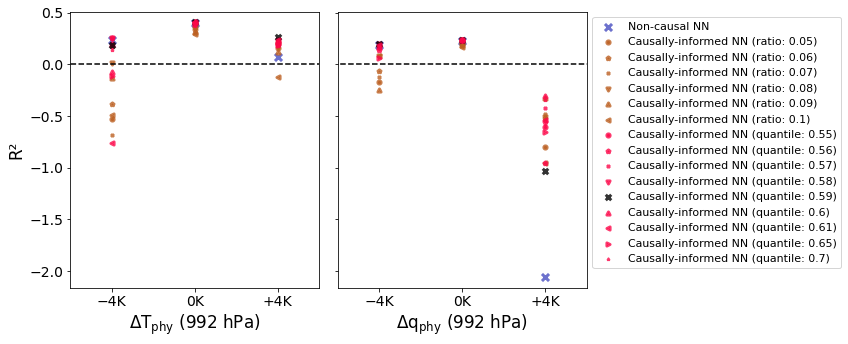

In [167]:
# Plotting
plot_r2_single_level(
    setup,
#     eval_dict,
    eval_klevels_dict,
    sens_dict,
    29,
    '992',
#     rasp_dict=rasp_dict,
    title='',
    decplc=1,
    eval_keys=['SingleNN'],
    # save=False,
    save='./plots',
    linewidth=3.
)

# Profile plots

In [94]:
# adapted from neural_networks.model_diagnostics import plot_profiles
def plot_profiles(
    setup,
    case,
    eval_dict,
    sens_dict,
    sens_keys=False,
    rasp_dict=False,
    style='scatter',
    decplc=2,
    title='', 
    eval_keys=False,
    save=False,
    savenm=False,
    **kwargs
):

    spcam_outputs = [i.value for i in setup.spcam_outputs]
    eval_keys = eval_dict.keys() if not eval_keys else eval_keys
    sens_keys = sens_dict.keys() if not sens_keys else sens_keys
    
    mpl.rcParams['font.size']      = 14
    
    n_cols = len(spcam_outputs)
    fig, ax = plt.subplots(1, n_cols, figsize=(12, 5))
    
    # Sensitivities
    #     markers = [iKey for iKey in Line2D.markers.keys()]
    markers = ['x','o','*','+','x','v','^','<','>','1','2','3','4','8','s','p','h','D']
    linestyles = ['--',':']
    for i, iVar in enumerate(spcam_outputs):
        
        # Rasp et al. (2018)
        if rasp_dict:
            stats = ma.round(rasp_dict[iVar][statsnm][1],decplc)
            if style == 'scatter':
                ax[i].scatter(
                    stats,
                    P,
                    label=rasp_dict[iVar]['lab'],
                    alpha=1.,
                    color='grey',
                    marker='.',
                    s=50,
                )
            else:
                ax[i].plot(
                    stats,
                    P,
                    label=rasp_dict[iVar]['lab'],
                    alpha=1.,
                    color='grey',
                    linestyle='-',
                    **kwargs
                )
        
        markers_count = 0; markers_swap = False
        for j, jMod in enumerate(sens_keys):
            thrs = jMod.split('_')[-1]
            color = '#fd084a' if float(thrs) > 0.2 else '#bc6022'
            markers_count = 0 if float(thrs) > 0.2 and not markers_swap else markers_count
            markers_swap = True if float(thrs) > 0.2 else markers_swap
            stats = ma.round(sens_dict[jMod][iVar][statsnm][1],decplc)
            if style == 'scatter':
                ax[i].scatter(
                    stats,
                    P,
                    label=sens_dict[jMod][iVar]['lab'],
                    alpha=.8,
                    color=color,
                    marker=markers[markers_count],
                    s=50,
                )
            else:
                ax[i].plot(
                    stats,
                    P,
                    label=sens_dict[jMod][iVar]['lab'],
                    alpha=.8,
                    color=color,
                    linestyle=linestyles[markers_count],
                    **kwargs
                )
            markers_count += 1
        print()

    # Reference
    colors = ['#494fc1','#fd084a','grey','#ff7f0e']
    for i, iVar in enumerate(spcam_outputs):
        for j, jMod in enumerate(eval_keys):
            stats = ma.round(eval_dict[jMod][iVar][statsnm][1],decplc)
            if style == 'scatter':
                ax[i].scatter(
                    stats,
                    P[:len(eval_dict[jMod][iVar][statsnm][1])],
                    label=eval_dict[jMod][iVar]['lab'],
                    alpha=.8,
                    color=colors[j],
                    marker='.',
                    s=50,
    #                 **kwargs
                )
            else:
                ax[i].plot(
                    stats,
                    P[:len(eval_dict[jMod][iVar][statsnm][1])],
                    label=eval_dict[jMod][iVar]['lab'],
                    alpha=.8,
                    color=colors[j],
                    linestyle='-',
                    **kwargs
                )
            
            if j == 0:
                ax[i].vlines(
                    0, P[:len(eval_dict[jMod][iVar][statsnm][1])][0], 
                    P[:len(eval_dict[jMod][iVar][statsnm][1])][-1], 
                    colors='k', 
                    linestyles='--',
                )
                ax[i].set_ylim(
                    P[:len(eval_dict[jMod][iVar][statsnm][1])][0]+10, 
                    P[:len(eval_dict[jMod][iVar][statsnm][1])][-1]+10
                )
                ax[i].invert_yaxis()
                ax[i].set_ylabel('Pressure (hPa)')
                if case == '0k':
                    ax[i].set_xlim(-.1, 1.)
                elif case == 'm4k':
                    ax[i].set_xlim(-.5, 1.)
                else:
                    ax[i].set_xlim(-2., 1.)
                ax[i].set_xlabel(f'{iVar} ({eval_dict[jMod][iVar][statsnm][0]})')
                ax[i].set_ylabel('Pressure (hPa)')
                ax[i].legend(loc=0,fontsize='small')
    
    plt.tight_layout()
    
    fig.suptitle(title)
    if save is not False: 
        savenm = 'r2_key-levels.png' if not savenm else savenm
        Path(save).mkdir(parents=True, exist_ok=True)
        fig.savefig(f"{save}/{savenm}")
        print(f"{save}/{savenm}")
    plt.show()

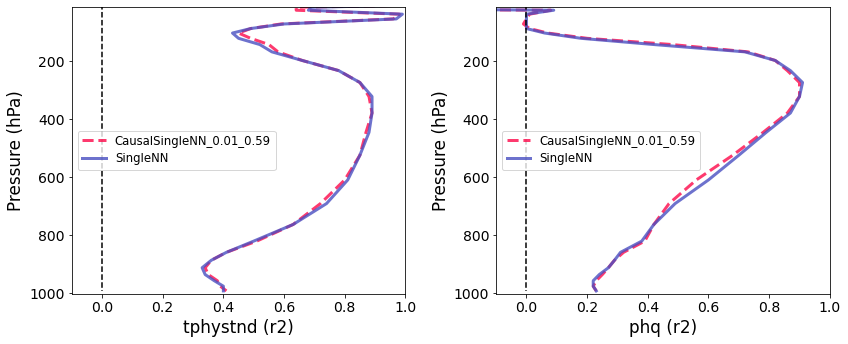

In [96]:
# Plot profile
case='0k' # '0k'; 'm4k'; 'p4k'
decplc=2
plot_profiles(
    setup,
    case,
    eval_dict[case],
#     eval_klevels_dict[case],
    sens_dict[case],
#     sens_keys=['CausalSingleNN_0.01_0.56','CausalSingleNN_0.01_0.58','CausalSingleNN_0.01_0.59'],
    sens_keys=['CausalSingleNN_0.01_0.59'],
    # rasp_dict=rasp_dict[case],
    style='line', # 'scatter'; 'line'
    decplc=decplc,
    title='',
    eval_keys=['SingleNN'],
#     save=False,
#     save='./plots',
#     savenm=f'r2_quantile-0.58-0.59_key-levels_{case}.png',
    linewidth=3.
)